# Test om koden er riktig implementert

Her er et forslag til testfunksjoner for å sjekke om koden er riktig implementert.
```assert variabel``` vil gi en feilmelding med mindre variabelen ```variabel = True```. For eksempel vil ```assert a == b``` gi en feilmelding med mindre ```a``` og ```b``` er like.

In [45]:
#For eksempel:
variable = True
assert variable, "You need to change 'variable' to True"

In [46]:
from layers import *
from neural_network import NeuralNetwork
from utils import onehot
import numpy as np
import matplotlib.pyplot as plt
from data_generators import get_train_test_sorting

In [47]:
#We choose some arbitrary values for the dimensions
b = 6
n_max = 7
m = 8
n = 5

d = 10
k = 5
p = 20

#Create an arbitrary dataset
x = np.random.randint(0, m, (b,n))
y = np.random.randint(0, m, (b,n_max))

#initialize the layers
feed_forward = FeedForward(d,p)
attention = Attention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed = LinearLayer(d,m)
softmax = Softmax()


#a manual forward pass
X = onehot(x, m)

z0 = embed_pos.forward(X)
z1 = feed_forward.forward(z0)
z2 = attention.forward(z1)
z3 = un_embed.forward(z2)
Z = softmax.forward(z3) 


#check the shapes
assert X.shape == (b,m,n), f"X.shape={X.shape}, expected {(b,m,n)}"
assert z0.shape == (b,d,n), f"z0.shape={z0.shape}, expected {(b,d,n)}"
assert z1.shape == (b,d,n), f"z1.shape={z1.shape}, expected {(b,d,n)}"
assert z2.shape == (b,d,n), f"z2.shape={z2.shape}, expected {(b,d,n)}"
assert z3.shape == (b,m,n), f"z3.shape={z3.shape}, expected {(b,m,n)}"
assert Z.shape == (b,m,n), f"Z.shape={Z.shape}, expected {(b,m,n)}"

#is X one-hot?
assert X.sum() == b*n, f"X.sum()={X.sum()}, expected {b*n}"


assert np.allclose(Z.sum(axis=1), 1), f"Z.sum(axis=1)={Z.sum(axis=1)}, expected {np.ones(b)}"
assert np.abs(Z.sum() - b*n) < 1e-5, f"Z.sum()={Z.sum()}, expected {b*n}"
assert np.all(Z>=0), f"Z={Z}, expected all entries to be non-negative"



In [48]:

#test the forward pass
x = np.random.randint(0, m, (b,n_max))
X = onehot(x, m)

#we test with a y that is shorter than the maximum length
n_y = n_max - 1
y = np.random.randint(0, m, (b,n_y))

#initialize a neural network based on the layers above
network = NeuralNetwork([embed_pos, feed_forward, attention, un_embed, softmax])
#and a loss function
loss = CrossEntropy()

#do a forward pass
Z = network.forward(X)

#compute the loss
L = loss.forward(Z, y)

#get the derivative of the loss wrt Z
grad_Z = loss.backward()
#and perform a backward pass
_ = network.backward(grad_Z)

#and and do a gradient descent step
_ = network.step_gd(0.01)

In [49]:
"""
Here you may add additional tests to for example:
- Check if the ['d'] keys in the parameter dictionaries are not None, or receive something when running backward pass
- Check if the parameters change when you perform a gradient descent step
- Check if the loss decreases when you perform a gradient descent step

This is voluntary, but could be useful.
"""

"\nHere you may add additional tests to for example:\n- Check if the ['d'] keys in the parameter dictionaries are not None, or receive something when running backward pass\n- Check if the parameters change when you perform a gradient descent step\n- Check if the loss decreases when you perform a gradient descent step\n\nThis is voluntary, but could be useful.\n"

In [50]:
#check if loss is non-negative
assert L >= 0, f"L={L}, expected L>=0"
assert grad_Z.shape == Z.shape, f"grad_Z.shape={grad_Z.shape}, expected {Z.shape}"

#check if onehot(y) gives zero loss
Y = onehot(y, m)
L = loss.forward(Y, y)
assert L < 1e-5, f"L={L}, expected L<1e-5"


In [51]:
# feed_forward1 = FeedForward(d,p)
# attention1 = Attention(d,k)
# embed_pos = EmbedPosition(n_max,m,d)
# un_embed_pos = LinearLayer(d,m)
# softmax = Softmax()
# layers = [embed_pos,attention1,feed_forward1,un_embed_pos, softmax]
# nueralnet = NeuralNetwork(layers)

b = 6
n_max = 7
m = 8
n = 5

d = 10
k = 5
p = 20
alpha = 0.0001
n_iter = 100

x = np.random.randint(0, m, (b,n_max))
y = np.random.randint(0, m, (b,n_max-1))
loss = CrossEntropy()
feed_forward1 = FeedForward(d,p)
attention1 = Attention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed_pos = LinearLayer(d,m)
softmax = Softmax()
layers = [embed_pos, attention1,feed_forward1, un_embed_pos, softmax]
nueralnettest = NeuralNetwork(layers)

def algorithm_4(x, y,n_iter,alpha, m , nueralnet):
    
    

    
    Losses = []
    for j in range(1,n_iter):
        X = onehot(x, m)
        Z = nueralnet.forward(X) 
        Losses.append(loss.forward(Z,y))
        dLdz = loss.backward()
        nueralnet.backward(dLdz) 
        nueralnet.step_adam(j,alpha)
        print(f'loss for iteration {j}: {loss.forward(Z,y)}') 
    return Losses   

arr = algorithm_4(x, y,n_iter, alpha, m, nueralnettest)



loss for iteration 1: 2.079771088891695
loss for iteration 2: 2.0796194125886682
loss for iteration 3: 2.079467916763475
loss for iteration 4: 2.0793166219230854
loss for iteration 5: 2.0791653939670036
loss for iteration 6: 2.0790142345922984
loss for iteration 7: 2.0788630431340756
loss for iteration 8: 2.0787116859568253
loss for iteration 9: 2.078560241381144
loss for iteration 10: 2.078408737799908
loss for iteration 11: 2.0782569267707265
loss for iteration 12: 2.0781048747613027
loss for iteration 13: 2.077952767504268
loss for iteration 14: 2.0778006248857452
loss for iteration 15: 2.0776484612486628
loss for iteration 16: 2.0774962865053883
loss for iteration 17: 2.0773441069051835
loss for iteration 18: 2.077191925634803
loss for iteration 19: 2.077039742103436
loss for iteration 20: 2.0768875561577476
loss for iteration 21: 2.076735365788364
loss for iteration 22: 2.07658316687171
loss for iteration 23: 2.076430954469617
loss for iteration 24: 2.0762787230443616
loss for ite

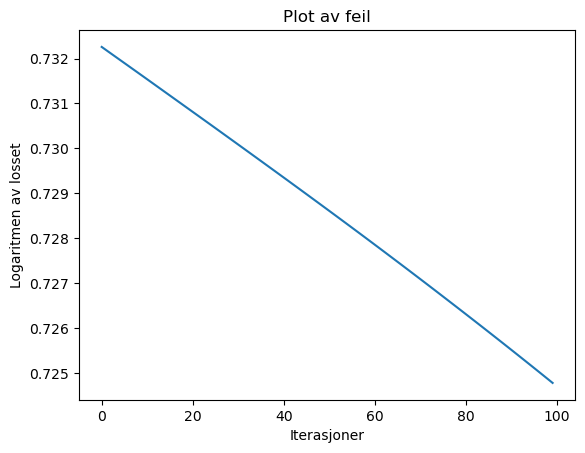

In [52]:
plt.plot(np.linspace(0,len(arr),len(arr)),np.log(arr))
plt.xlabel('Iterasjoner')
plt.ylabel('Logaritmen av losset')
plt.title('Plot av feil')
plt.show()

In [53]:
#training the module
r = 5
m = 2
d = 10
k = 5
p = 15
L = 2
n_max = 2*r - 1
n_iter = 300
alpha = 0.00005

data = get_train_test_sorting(r, m, 250, 10,10)

loss = CrossEntropy()
feed_forward1 = FeedForward(d,p)
attention1 = Attention(d,k)
embed_pos = EmbedPosition(n_max,m,d)
un_embed_pos = LinearLayer(d,m)
softmax = Softmax()
layers = [embed_pos, attention1,feed_forward1, un_embed_pos, softmax]
nueralnetsort = NeuralNetwork(layers)

x = data['x_train'][0]
y = data['y_train'][0]

arr2 = algorithm_4(x, y, n_iter, alpha, m ,  nueralnetsort)

loss for iteration 1: 0.8921399126193315
loss for iteration 2: 0.8913670395354997
loss for iteration 3: 0.8906018445194882
loss for iteration 4: 0.8898452812883492
loss for iteration 5: 0.8890970657115503
loss for iteration 6: 0.8883564300502544
loss for iteration 7: 0.8876227418100817
loss for iteration 8: 0.886895650677888
loss for iteration 9: 0.8861749341250672
loss for iteration 10: 0.8854600617300726
loss for iteration 11: 0.8847506195320908
loss for iteration 12: 0.8840461689118319
loss for iteration 13: 0.8833462484521967
loss for iteration 14: 0.8826503817609623
loss for iteration 15: 0.8819580894767397
loss for iteration 16: 0.8812689032674459
loss for iteration 17: 0.8805823788887505
loss for iteration 18: 0.8798981054052059
loss for iteration 19: 0.8792157088975843
loss for iteration 20: 0.8785348509987093
loss for iteration 21: 0.877855207239389
loss for iteration 22: 0.8771774591242628
loss for iteration 23: 0.8764999695837385
loss for iteration 24: 0.8758222450874071
los

In [57]:
x_t = data['x_test'][0]
y_t = data['y_test'][0]
def sorting(neuralnet, x, y):
    X = onehot(x, m)
    Z = neuralnet.forward(X)
    amount = 0
    total = 0


    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if x[i][j] == y[i][j]:
                amount += 1
            total+=1
    return amount/total

per = sorting(nueralnetsort, x_t, y_t)
print(f'prosent riktig er {per*100}')
    

prosent riktig er 59.199999999999996
